In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('punkt')

import datetime as dt
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout ,LSTM
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GMEClosePriceSentimentData(2020-2022).csv")
data.head()

,title,timestamp,Positive,Neutral,Negative,Close
0,if everyone buys and holds gme does that mean ...,2021-01-28,0.000001,1.000001,0.000001,48.400002
1,i didnknow about gamestop until it was to late...,2021-01-28,0.000001,1.000001,0.000001,48.400002
2,canlook up gamestop,2021-01-28,0.000001,1.000001,0.000001,48.400002
3,short sellers made billions froms tech selloff...,2021-01-28,0.000001,0.787001,0.213001,48.400002
4,short sellers made 3 6 bln in profits so far t...,2021-01-28,0.191001,0.712001,0.097001,48.400002


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60

x_train = []
y_train = []

for x in range (prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
x_train , y_train = np.array(x_train) , np.array(y_train)

x_train = np.reshape(x_train , (x_train.shape[0],x_train.shape[1] , 1))

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True , input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True)) 
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam' , loss = 'mean_squared_error',metrics = 'accuracy' )
model.fit(x_train,y_train,epochs = 10 , batch_size = 32)

Epoch 1/10
18/18 [==============================] - 5s 56ms/step - loss: 0.0864 - accuracy: 0.2473
Epoch 2/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0202 - accuracy: 0.3127
Epoch 3/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0162 - accuracy: 0.3127
Epoch 4/10
18/18 [==============================] - 1s 56ms/step - loss: 0.0147 - accuracy: 0.3127
Epoch 5/10
18/18 [==============================] - 1s 58ms/step - loss: 0.0132 - accuracy: 0.3127
Epoch 6/10
18/18 [==============================] - 1s 55ms/step - loss: 0.0167 - accuracy: 0.3127
Epoch 7/10
18/18 [==============================] - 1s 59ms/step - loss: 0.0159 - accuracy: 0.3127
Epoch 8/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0139 - accuracy: 0.3127
Epoch 9/10
18/18 [==============================] - 1s 56ms/step - loss: 0.0114 - accuracy: 0.3127
Epoch 10/10
18/18 [==============================] - 1s 52ms/step - loss: 0.0122 - accuracy: 0.3127


In [ ]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

stock_ticker = 'GME'

start = pd.to_datetime(['2007-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2020-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
test_data = pd.read_csv(url)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

model_inputs = model_inputs.reshape(-1 , 1)

model_inputs = scaler.transform(model_inputs)


In [ ]:
x_test = []

for x in range(prediction_days , len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x , 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

111/111 [==============================] - 3s 20ms/step


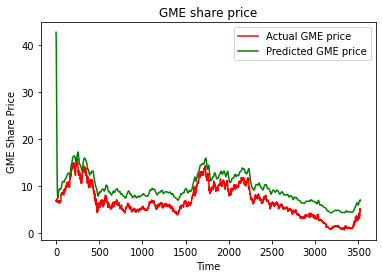

In [ ]:
plt.plot(actual_prices, color = "red" , label = f"Actual {company} price")
plt.plot(predicted_prices , color = "green" , label = f"Predicted {company} price" )
plt.title(f"{company} share price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [ ]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1) , 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f"prediction : {prediction}")

1/1 [==============================] - 0s 16ms/step
prediction : [[7.174166]]
